In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
train_features = pd.read_csv('FLU_VACCINE_ML/training_set_features.csv')
train_labels = pd.read_csv('FLU_VACCINE_ML/training_set_labels.csv')
test_features = pd.read_csv('FLU_VACCINE_ML/test_set_features.csv')

In [17]:
X = train_features.drop(columns=['respondent_id'])
x_test = test_features.drop(columns=['respondent_id'])
y_h1n1 = train_labels['h1n1_vaccine']
y_Seasonal = train_labels['seasonal_vaccine']
print(X.shape, y_h1n1.shape, y_Seasonal.shape)

(26707, 35) (26707,) (26707,)


In [18]:
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(exclude=['object']).columns

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
numeric_transformer = Pipeline(steps=(
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
))
categorical_Transformer = Pipeline(steps=(
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore' , sparse_output=False))

))
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_Transformer, categorical_cols)
    ]
)
pipeline_hgb = Pipeline(steps=(
    ('preprocess', preprocessor),
    ('model', HistGradientBoostingClassifier(
        max_depth=7,
        learning_rate=0.05,
        max_iter=300,
        random_state=42
    ))
))

pipeline_hgb.fit(X_train, y_h1n1_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [31]:
from sklearn.metrics import roc_auc_score
y_val_pred_probab = pipeline_hgb.predict_proba(X_val)[:,1]
roc_h1n1_hgb = roc_auc_score(y_h1n1_val, y_val_pred_probab)
print('H1N1 ROC AUC SCORE HISTBOOSTGRADIENT: ', roc_h1n1_hgb)

H1N1 ROC AUC SCORE HISTBOOSTGRADIENT:  0.833851070535891


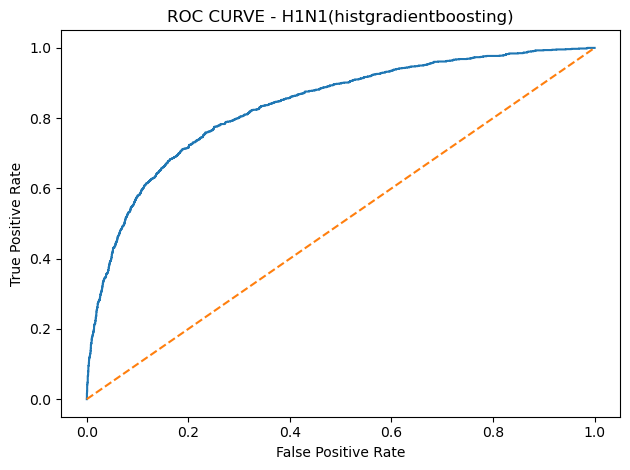

In [33]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(y_h1n1_val, y_val_pred_probab)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1],linestyle = '--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE - H1N1(histgradientboosting)')
plt.tight_layout()
plt.show()


In [40]:
y_seasonal = train_labels['seasonal_vaccine']


In [46]:
from sklearn.model_selection import train_test_split
_, _, y_seasonal_train, y_seasonal_val = train_test_split(
    X, y_seasonal,
    test_size = 0.2,
    random_state = 42
)

In [49]:
from sklearn.ensemble import HistGradientBoostingClassifier
hgb_Seasonal = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter = 300,
    max_leaf_nodes= 31,
    min_samples_leaf= 50,
    random_state=42
)
pipeline_hgb_seasonal = Pipeline(steps = (
    ('preprocess', preprocessor),
    ('model', hgb_Seasonal)
))

In [51]:
pipeline_hgb_seasonal.fit(X_train, y_seasonal_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [55]:
from sklearn.metrics import roc_auc_score
y_val_pred_Seasonal_probab = pipeline_hgb_seasonal.predict_proba(X_val)[:,1]
roc_Seasonal_hgb = roc_auc_score(y_seasonal_val, y_val_pred_Seasonal_probab)
print('SEASONAL ROC AUC HGB SCORE: ', roc_Seasonal_hgb)

SEASONAL ROC AUC HGB SCORE:  0.4908448411416514


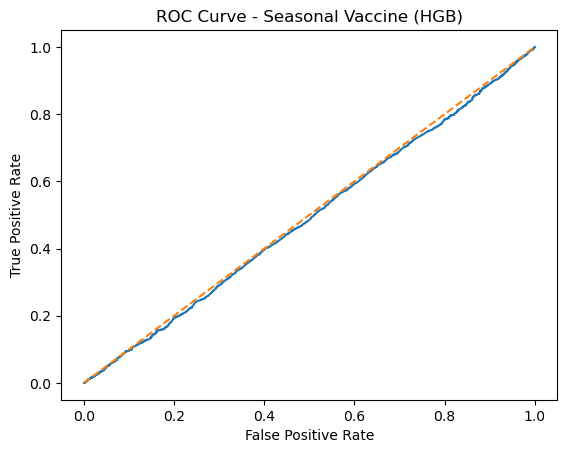

In [58]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_seasonal_val, y_val_pred_Seasonal_probab)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Seasonal Vaccine (HGB)")
plt.show()


In [60]:
from sklearn.linear_model import LogisticRegression
pipe_lr = Pipeline(steps=(
    ('preprocess', preprocessor),
    ('model', LogisticRegression(
        max_iter=1000
    ))
))
pipe_lr.fit(X_train, y_seasonal_train)
roc_auc_score(
    y_seasonal_val,
    pipe_lr.predict_proba(X_val)[:,1]
)

0.5069909132874983

Despite evaluating Logistic Regression and Histogram Gradient Boosting with proper preprocessing and validation, the Seasonal Vaccine target consistently produced ROC–AUC ≈ 0.50, indicating lack of separable signal in the provided features.